In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest
from cycler import cycler

In [40]:
harmony_data = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Reservoir Engineering\Datasets\Oil Production\Harmony_data.csv')
IHS_data = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Reservoir Engineering\Datasets\Oil Production\IHS_data.csv')
train_data = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Reservoir Engineering\Datasets\Oil Production\production_data_train.csv', parse_dates=[['Month', 'Year']])
test_data = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Reservoir Engineering\Datasets\Oil Production\production_data_test.csv', parse_dates=['date'])
test_APIs = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Reservoir Engineering\Datasets\Oil Production\Test_APIs.csv')
test_APIs.shape, harmony_data.shape, IHS_data.shape, train_data.shape, test_data.shape,

((1134, 1), (8930, 7), (9224, 14), (394074, 9), (6489, 11))

## Exploratory Data Analysis

In [41]:
harmony_data.head(3)

,API,LATERAL_LENGTH_BLEND,PROP_PER_FOOT,WATER_PER_FOOT,GOR_30,GOR_60,GOR_90
0,5123371740000,9056,1025.8680,790.7205,2300.919963,2290.231375,2171.635752
1,5123377360000,4101,NaN,NaN,3786.669639,3838.096579,4012.142621
2,5123378210000,4161,916.0801,839.9280,2399.490505,2291.864862,2472.275585


In [42]:
IHS_data.head(2)

,API,PermitDate,SpudDate,CompletionDate,FirstProductionDate,operatorNameIHS,formation,BasinName,StateName,CountyName,LatWGS84,LonWGS84,BottomHoleLatitude,BottomHoleLongitude
0,33105037530000,2014-09-10,2014-12-31,2015-05-05,2015-03-01 00:00:00.000,CONTINENTAL RESOURCES INCORPORATED,BAKKEN,WILLISTON BASIN,NORTH DAKOTA,WILLIAMS,48.227596,-103.299600,48.2546,-103.29997
1,33105032020000,2013-09-09,2013-11-02,2014-04-28,2014-04-01 00:00:00.000,CONTINENTAL RESOURCES INCORPORATED,BAKKEN,WILLISTON BASIN,NORTH DAKOTA,WILLIAMS,48.230954,-103.189754,48.1983,-103.19195


In [43]:
train_data.head(2)

,Month_Year,API,Liquid,Gas,RatioGasOil,Water,PercentWater,DaysOn,_LastUpdate
0,2015-03-01,33053063590000,17186,26624,1.549168,8213,0.477889,16,2016-08-11 14:03:14.000
1,2015-04-01,33053063590000,18796,21796,1.159608,7255,0.385986,30,2016-08-11 14:03:14.000


In [44]:
test_data.head(2)

,API,Year,Month,Liquid,Gas,RatioGasOil,Water,PercentWater,DaysOn,_LastUpdate,date
0,33053052530100,2014,7,19518,34414,1.763193,10786,0.552618,31,2016-04-06 13:48:08.990,2014-07-01
1,33053052530100,2014,8,18632,32250,1.730893,9959,0.534511,31,2016-04-06 13:48:08.990,2014-08-01


In [45]:
train_data.Month_Year.describe(datetime_is_numeric=True)

count                           394074
mean     2016-10-08 05:38:51.759010048
min                1977-10-01 00:00:00
25%                2015-11-01 00:00:00
50%                2016-11-01 00:00:00
75%                2017-12-01 00:00:00
max                2019-02-01 00:00:00
Name: Month_Year, dtype: object

In [46]:
test_data.date.describe(datetime_is_numeric=True)

count                             6489
mean     2015-08-12 07:16:43.606102528
min                2008-09-01 00:00:00
25%                2014-11-01 00:00:00
50%                2015-05-01 00:00:00
75%                2016-01-01 00:00:00
max                2019-01-01 00:00:00
Name: date, dtype: object

In [47]:
test_data.set_index('date', inplace=True)
test_data.drop(['Year','Month'], axis=1, inplace=True)

In [48]:
test_data.head(2)

,API,Liquid,Gas,RatioGasOil,Water,PercentWater,DaysOn,_LastUpdate
date,,,,,,,,
2014-07-01,33053052530100,19518,34414,1.763193,10786,0.552618,31,2016-04-06 13:48:08.990
2014-08-01,33053052530100,18632,32250,1.730893,9959,0.534511,31,2016-04-06 13:48:08.990


In [49]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394074 entries, 0 to 394073
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Month_Year    394074 non-null  datetime64[ns]
 1   API           394074 non-null  int64         
 2   Liquid        394074 non-null  int64         
 3   Gas           394074 non-null  int64         
 4   RatioGasOil   394074 non-null  float64       
 5   Water         394074 non-null  int64         
 6   PercentWater  394074 non-null  float64       
 7   DaysOn        394074 non-null  int64         
 8   _LastUpdate   394074 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(5), object(1)
memory usage: 27.1+ MB


#### Checking null values

In [50]:
# Check for missing values
train_data.isnull().sum()

Month_Year      0
API             0
Liquid          0
Gas             0
RatioGasOil     0
Water           0
PercentWater    0
DaysOn          0
_LastUpdate     0
dtype: int64

In [51]:
IHS_data.isnull().sum()

API                      0
PermitDate               0
SpudDate                 0
CompletionDate           0
FirstProductionDate    183
operatorNameIHS          0
formation                0
BasinName                0
StateName                0
CountyName               0
LatWGS84                 0
LonWGS84                 0
BottomHoleLatitude       0
BottomHoleLongitude      0
dtype: int64

In [52]:
harmony_data.isnull().sum()

API                       0
LATERAL_LENGTH_BLEND      0
PROP_PER_FOOT           460
WATER_PER_FOOT          633
GOR_30                  135
GOR_60                  135
GOR_90                  135
dtype: int64

### Compare the number of wells

In [53]:
# IHS_data Number of wells
IHS_data.API.unique().shape

(8930,)

In [54]:
# Harmony_data Number of wells
harmony_data.API.unique().shape

(8930,)

In [55]:
# Train_data + test_data number of wells
train_data.API.unique().shape[0] + test_data.API.unique().shape[0]

8973

In [56]:
# test_data Number of wells
test_data.API.unique().shape

(1129,)

In [57]:
# Get repetead wells in train and test data
repetead_wells = []
for well in train_data.API.unique():
    if well in test_data.API.unique():
        repetead_wells.append(well)

print(len(repetead_wells))

43


#### Check values of each column

In [58]:
# Compare the same WELL in test and test data
train_data[(train_data['API']) == 42301322730000][5:10]

,Month_Year,API,Liquid,Gas,RatioGasOil,Water,PercentWater,DaysOn,_LastUpdate
393178,2016-11-01,42301322730000,2232,32100,14.381720,27628,12.378136,0,2018-07-08 10:03:10.183
393179,2016-12-01,42301322730000,2506,31466,12.556265,27082,10.806864,0,2018-07-08 10:03:10.183
393180,2017-01-01,42301322730000,2484,34719,13.977053,29882,12.029791,0,2018-07-08 10:03:10.183
393181,2017-02-01,42301322730000,2180,26156,11.998165,22512,10.326606,0,2018-07-08 10:03:10.183
393182,2017-03-01,42301322730000,2281,22903,10.040772,19712,8.641824,0,2018-11-04 10:19:16.577


In [59]:
# Compare the same WELL in test and test data
test_data[(test_data['API'] == 42301322730000)]

,API,Liquid,Gas,RatioGasOil,Water,PercentWater,DaysOn,_LastUpdate
date,,,,,,,,
2015-02-01,42301322730000,10801,36697,3.397556,31584,2.924174,0,2018-11-04 10:19:16.577
2015-03-01,42301322730000,17497,78231,4.471109,67331,3.848145,0,2018-11-04 10:19:16.577
2015-04-01,42301322730000,12283,65415,5.325653,56301,4.583652,0,2018-11-04 10:19:16.577
2015-05-01,42301322730000,9661,64795,6.706863,55767,5.772384,0,2018-11-04 10:19:16.577


In [60]:
# Check if all the wells in test data are in harmony_data and IHS_data
set(test_APIs.index.unique()) - set(harmony_data.index.unique()), set(test_APIs.index.unique()) - set(IHS_data.index.unique())

(set(), set())

In [61]:
# IHS data has more observations than harmony data and wells, it is necessary to verify data that are duplicated 
IHS_data[IHS_data.API.isin(list(IHS_data.API[IHS_data.API.duplicated()]))].head(6)

,API,PermitDate,SpudDate,CompletionDate,FirstProductionDate,operatorNameIHS,formation,BasinName,StateName,CountyName,LatWGS84,LonWGS84,BottomHoleLatitude,BottomHoleLongitude
272,42301320940000,2014-01-02,2014-02-19,2014-04-17,NaN,WPX ENERGY PRODUCTION LLC,BONE SPRING,PERMIAN BASIN,TEXAS,LOVING,31.942399,-103.870208,31.95571,-103.86969
281,42301322750000,2014-08-09,2015-04-08,2015-07-21,NaN,EOG RESOURCES INCORPORATED,BONE SPRING,PERMIAN BASIN,TEXAS,LOVING,31.971822,-103.626594,31.95668,-103.62589
289,42301323710000,2014-10-10,2014-12-18,2015-05-27,2016-01-01 00:00:00.000,APACHE CORPORATION,BONE SPRING,PERMIAN BASIN,TEXAS,LOVING,31.751439,-103.614968,31.73676,-103.63004
290,42301323710000,2014-10-10,2014-12-18,2015-05-27,2015-05-01 00:00:00.000,APACHE CORPORATION,BONE SPRING,PERMIAN BASIN,TEXAS,LOVING,31.751439,-103.614968,31.73676,-103.63004
310,42301326020000,2015-05-21,2015-06-20,2015-08-05,NaN,EOG RESOURCES INCORPORATED,BONE SPRING,PERMIAN BASIN,TEXAS,LOVING,31.986463,-103.619420,31.99981,-103.62003
316,42109325790000,2013-05-29,2013-08-10,2014-02-17,NaN,COG OPERATING LIMITED LIABILITY CORP,BONE SPRING,PERMIAN BASIN,TEXAS,CULBERSON,31.986781,-104.033066,31.99947,-104.03214


In [62]:
# Drop duplicated wells in IHS data
IHS_data_nd = IHS_data.drop_duplicates(subset=['API']).reset_index()
IHS_data_nd.shape

(8930, 15)

In [63]:
# Map the IHS_data to train_dat and test_data
for column in IHS_data_nd.columns:
    train_data[column + '_new'] = train_data['API'].map(dict(zip(IHS_data_nd.API, IHS_data_nd[column])))

for column in IHS_data_nd.columns:
    test_data[column + '_new'] = test_data['API'].map(dict(zip(IHS_data_nd.API, IHS_data_nd[column])))

In [64]:
# Map the harmony_data to the test_data
for column in harmony_data.columns:
    train_data[column + '_new'] = train_data['API'].map(dict(zip(harmony_data.API, harmony_data[column])))

for column in harmony_data.columns:
    test_data[column + '_new'] = test_data['API'].map(dict(zip(harmony_data.API, harmony_data[column])))

In [65]:
# Drop columns with no relevance
train_df = train_data.drop(['index_new', 'API_new','PermitDate_new','FirstProductionDate_new','SpudDate_new','CompletionDate_new','LatWGS84_new','LonWGS84_new', 'GOR_30_new', 'GOR_60_new', 'GOR_90_new', '_LastUpdate'], axis=1)
test_df = test_data.drop(['index_new', 'API_new','PermitDate_new','FirstProductionDate_new','SpudDate_new','CompletionDate_new','LatWGS84_new','LonWGS84_new', 'GOR_30_new', 'GOR_60_new', 'GOR_90_new', '_LastUpdate'], axis=1)

In [66]:
# Rename date column to match test_data
train_df.rename(columns={'Month_Year':'date'}, inplace=True)

In [67]:
# Set date as index
train_df.set_index('date', inplace=True)

In [68]:
# Check if test_df and test_df have the same columns
set(train_df.columns) - set(test_df.columns)

set()

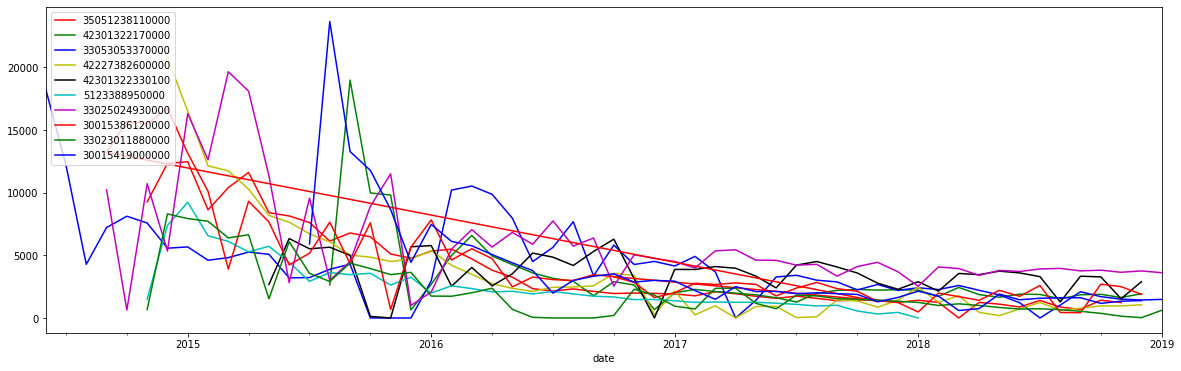

In [69]:
# Plot some random wells from train_df to see their behaviour
np.random.seed(82)
random_wells = np.random.choice(train_df.API.unique(), 10)

for well in random_wells:
    train_df[(train_df['API'] == well)]['Liquid'].plot(figsize=(20, 6))

plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y', 'k', 'c', 'm', 'r', 'g', 'b', 'y', 'k', 'c', 'm','b','y']))) 
plt.legend(random_wells, loc='upper left')
plt.show()

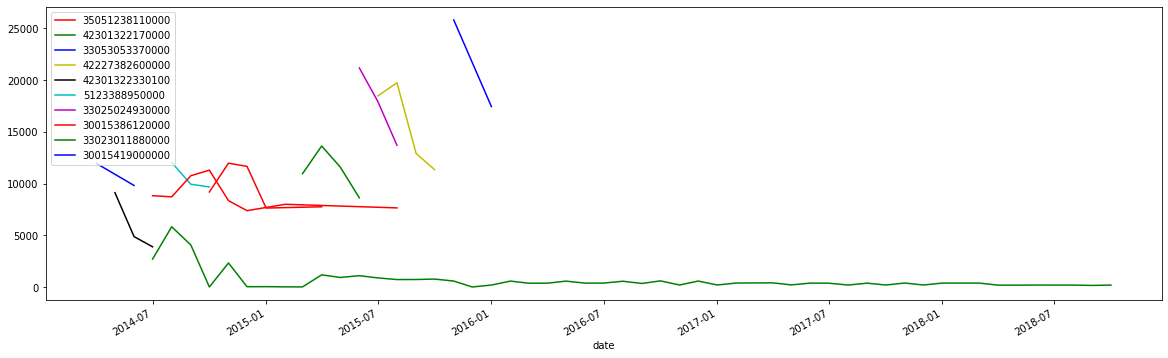

In [70]:
# Plot some random wells from test_df to see their behaviour
random_wells_test = np.random.choice(test_df.API.unique(), 10)

for well in random_wells_test:
    test_df[(test_df['API'] == well)]['Liquid'].plot(figsize=(20, 6))

plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y', 'k', 'c', 'm', 'r', 'g', 'b', 'y', 'k', 'c', 'm','b','y']))) 
plt.legend(random_wells, loc='upper left')
plt.show()

In [71]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 394074 entries, 2015-03-01 to 2018-09-01
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   API                       394074 non-null  int64  
 1   Liquid                    394074 non-null  int64  
 2   Gas                       394074 non-null  int64  
 3   RatioGasOil               394074 non-null  float64
 4   Water                     394074 non-null  int64  
 5   PercentWater              394074 non-null  float64
 6   DaysOn                    394074 non-null  int64  
 7   operatorNameIHS_new       394074 non-null  object 
 8   formation_new             394074 non-null  object 
 9   BasinName_new             394074 non-null  object 
 10  StateName_new             394074 non-null  object 
 11  CountyName_new            394074 non-null  object 
 12  BottomHoleLatitude_new    394074 non-null  float64
 13  BottomHoleLongitude_new   39

In [72]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6489 entries, 2014-07-01 to 2015-03-01
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   API                       6489 non-null   int64  
 1   Liquid                    6489 non-null   int64  
 2   Gas                       6489 non-null   int64  
 3   RatioGasOil               6489 non-null   float64
 4   Water                     6489 non-null   int64  
 5   PercentWater              6489 non-null   float64
 6   DaysOn                    6489 non-null   int64  
 7   operatorNameIHS_new       6489 non-null   object 
 8   formation_new             6489 non-null   object 
 9   BasinName_new             6489 non-null   object 
 10  StateName_new             6489 non-null   object 
 11  CountyName_new            6489 non-null   object 
 12  BottomHoleLatitude_new    6489 non-null   float64
 13  BottomHoleLongitude_new   6489 non-null   flo

In [73]:
# Check the features with missing values
train_df[train_df.PROP_PER_FOOT_new.isnull()].groupby('API').mean()[:3]

,Liquid,Gas,RatioGasOil,Water,PercentWater,DaysOn,BottomHoleLatitude_new,BottomHoleLongitude_new,LATERAL_LENGTH_BLEND_new,PROP_PER_FOOT_new,WATER_PER_FOOT_new
API,,,,,,,,,,,
5001097800000,307.812500,363.312500,1.148123,647.104167,1.172769,27.666667,39.92629,-104.71585,3983.0,NaN,NaN
5001097830000,317.472727,823.890909,1.874774,328.090909,0.455979,26.018182,39.92745,-104.71586,4027.0,NaN,NaN
5001098450000,4648.595238,11096.666667,3.275740,226.880952,0.057842,21.619048,39.95921,-104.84774,4315.0,NaN,NaN


In [74]:
# Check for duplicated values and get rid of them
train_df['I+API'] = train_df.index.astype(str) + train_df.API.astype(str)
test_df['I+API'] = test_df.index.astype(str) + test_df.API.astype(str)

train_df.drop_duplicates(subset=['I+API'], keep='last' ,inplace=True)
test_df.drop_duplicates(subset=['I+API'], keep='last',inplace=True)

In [75]:
# Check number of wells in test set are in test_APIs
set(test_APIs['API']) - set(test_df['API']) # One is not in the test set

{42301320120000}

In [76]:
test_df.shape, train_df.shape

((6489, 18), (394064, 18))

In [77]:
# Concatenate missing test_APIs from train_df into test_df set and drop from train_df set
test_df = pd.concat([test_df, train_df[(train_df.API == 42301320120000)]], axis=0)
train_df = train_df[~(train_df.API == 42301320120000)]

In [78]:
# Sort the test set based onto test_APIs
test_sorted = pd.DataFrame(columns=test_df.columns)

for well in test_APIs.API.unique():
    test_sorted = pd.concat([test_sorted, test_df[(test_df.API == well)]], axis=0)

In [79]:
# Concatenate train_df and test_df
df = pd.concat([train_df, test_sorted], axis=0)

In [80]:
# Fill the missing values with the bfill method
df.fillna(method='bfill', inplace=True)

In [81]:
# Change API column to string
df['API'] = df['API'].astype(str)

In [82]:
df.shape

(400553, 18)

In [83]:
# Function that transform object variables into categorical variables
def transform_object_variables(df):
    for label, content in df.items():
        if content.dtype == 'object':
            df[label] = pd.Categorical(content).codes + 1

In [84]:
transform_object_variables(df)

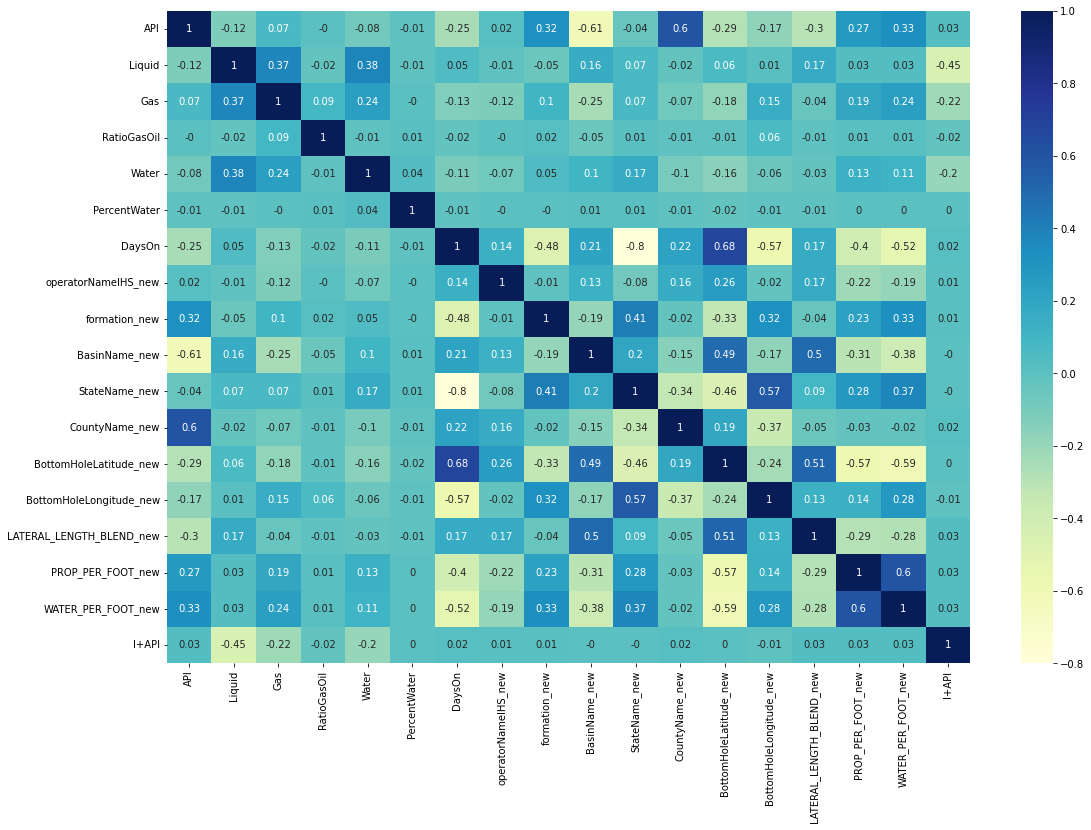

In [85]:
# Plotting correlation matrix
plt.figure(figsize=(18, 12))
sns.heatmap(round(df.corr(),2), annot=True, cmap='YlGnBu');

In [86]:
df.drop(['RatioGasOil', 'I+API', 'PercentWater', 'DaysOn', 'operatorNameIHS_new','formation_new','StateName_new','CountyName_new', 'BottomHoleLatitude_new','BottomHoleLongitude_new','PROP_PER_FOOT_new', 'WATER_PER_FOOT_new'], axis=1, inplace=True)

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 400553 entries, 2015-03-01 to 2015-09-01
Data columns (total 6 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   API                       400553 non-null  int16
 1   Liquid                    400553 non-null  int64
 2   Gas                       400553 non-null  int64
 3   Water                     400553 non-null  int64
 4   BasinName_new             400553 non-null  int8 
 5   LATERAL_LENGTH_BLEND_new  400553 non-null  int64
dtypes: int16(1), int64(4), int8(1)
memory usage: 16.4 MB


In [88]:
# Check if there are any duplicated values since train_df and test_df were concataned and drop duplicates keeping the last one(test_df)
df['I+API'] = df.index.astype(str) + df.API.astype(str)
df.drop_duplicates(subset=['I+API'], keep='last', inplace=True)
df.drop(['I+API'], axis=1, inplace=True)

In [89]:
df.reset_index(inplace=True)

In [90]:
# Sort values by date descending first
data = pd.DataFrame(columns=df.columns)
for well in df.API.unique():
    well = df[(df['API'] == well)].sort_values(by='index')
    data = pd.concat([data, well], axis=0)

In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400323 entries, 0 to 400322
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   index                     400323 non-null  object
 1   API                       400323 non-null  object
 2   Liquid                    400323 non-null  object
 3   Gas                       400323 non-null  object
 4   Water                     400323 non-null  object
 5   BasinName_new             400323 non-null  object
 6   LATERAL_LENGTH_BLEND_new  400323 non-null  object
dtypes: object(7)
memory usage: 24.4+ MB


In [92]:
data['index'] = pd.to_datetime(data['index'])

In [93]:
data.set_index(data['index'], inplace=True)
data.drop(['index'], axis=1, inplace=True)

In [129]:
df_filter = data.copy()

In [130]:
for column in df_filter.columns:
    df_filter[column] = df_filter[column].astype(int)

df_filter.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 400323 entries, 2015-03-01 to 2015-09-01
Data columns (total 6 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   API                       400323 non-null  int32
 1   Liquid                    400323 non-null  int32
 2   Gas                       400323 non-null  int32
 3   Water                     400323 non-null  int32
 4   BasinName_new             400323 non-null  int32
 5   LATERAL_LENGTH_BLEND_new  400323 non-null  int32
dtypes: int32(6)
memory usage: 12.2 MB


In [131]:
# Filtering out wells from the peak forward
for well in df_filter.API.unique():
    df_filter[(df_filter.API == well)] = df_filter[(df_filter.API == well)][(df_filter[(df_filter.API == well)].index >= df_filter[(df_filter.API == well)].Liquid.idxmax())]

df_filter.dropna(inplace=True)

In [155]:
batch_well_train = np.random.choice(df_filter.API.unique()[:-1130], 20)
df_f_train = df_filter[df_filter.API.isin(batch_well_train)]

In [ ]:
df_f_test = df_filter[df_filter.API.unique()[-1130:]]

In [153]:
df_f_test.API.unique().shape

NameError: name 'df_f_test' is not defined

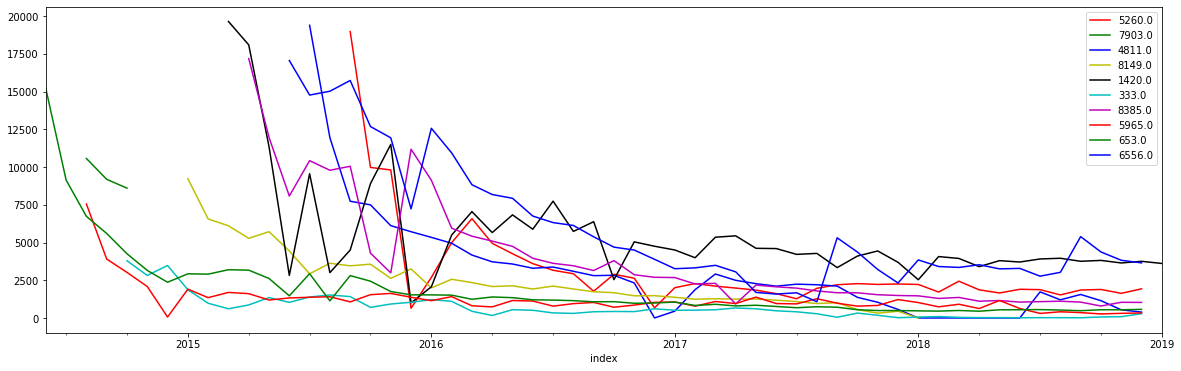

In [150]:
# Plot some random wells from df to see if the filter works out
np.random.seed(82)
random_wells_df = np.random.choice(df_filter.API.unique(), 10)

for well in random_wells_df:
    df_filter[(df_filter['API'] == well)]['Liquid'].plot(figsize=(20, 6))

plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y', 'k', 'c', 'm', 'r', 'g', 'b', 'y', 'k', 'c', 'm','b','y'])))
plt.legend(random_wells_df)
plt.show()

#### Splitting data into train and test sets

In [103]:
Y_train_set = df_filter.Liquid[:train_df.shape[0]]
exo_train_set = df_filter[:train_df.shape[0]].drop(['Liquid'], axis=1)
Y_test_set = df_filter.Liquid[train_df.shape[0]:]
exo_test_set = df_filter[train_df.shape[0]:].drop(['Liquid'], axis=1)

In [104]:
# Drop Nan from all data sets
Y_train_set.dropna(inplace=True)
exo_train_set.dropna(inplace=True)
Y_test_set.dropna(inplace=True)
exo_test_set.dropna(inplace=True)

In [105]:
# Convert all columns from string to integer
for column in exo_train_set.columns:
    exo_train_set[column] = exo_train_set[column].astype(int)

for column in exo_test_set.columns:
    exo_test_set[column] = exo_test_set[column].astype(int)

Y_train_set = Y_train_set.astype(int)
Y_test_set = Y_test_set.astype(int)

In [106]:
mod_auar_li = auto_arima(Y_train_set, exogenous=exo_train_set[['API', 'Gas', 'Water','BasinName_new','LATERAL_LENGTH_BLEND_new']], m=5, max_p=5, max_q=5)

KeyboardInterrupt: 